splitting the data into train and test to overcome overfitting 

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Use a professional plot style
if 'seaborn-v0_8-darkgrid' in plt.style.available:
    plt.style.use('seaborn-v0_8-darkgrid')
elif 'seaborn-darkgrid' in plt.style.available:
    plt.style.use('seaborn-darkgrid')
else:
    plt.style.use('ggplot')

# --- PARAMETERS ---
tickers = ["AMD", "MSFT", "NVDA", "TSM"]
capital = 100000
risk_per_trade = 0.01

# --- STRATEGY HYPERPARAMETERS ---
sma_period_long = 20
sma_period_short = 5
rsi_period = 7
rsi_buy = 50
rsi_sell = 70
atr_period = 14
atr_multiplier_stop = 2.0
atr_multiplier_take_profit = 4.0

# --- DATA FETCHING ---
def fetch_data(ticker, interval='5m', period='60d'):
    print(f"Fetching {interval} data for {ticker} over the last {period}...")
    data = yf.download(ticker, interval=interval, period=period, progress=False, auto_adjust=True)
    data.dropna(inplace=True)
    return data

# --- INDICATOR CALCULATION ---
def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).ewm(com=period - 1, min_periods=period).mean()
    loss = -delta.where(delta < 0, 0).ewm(com=period - 1, min_periods=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr(data, period=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    return true_range.ewm(com=period - 1, min_periods=period).mean()

# --- MACHINE LEARNING TRAINING ---
def prepare_ml_data(data):
    data['SMA_Long'] = data['Close'].rolling(window=sma_period_long).mean()
    data['SMA_Short'] = data['Close'].rolling(window=sma_period_short).mean()
    data['RSI'] = calculate_rsi(data, rsi_period)
    data['ATR'] = calculate_atr(data, atr_period)
    data['Target'] = (data['Close'].shift(-6) > data['Close']).astype(int)
    data.dropna(inplace=True)

    features = data[['RSI', 'SMA_Short', 'SMA_Long', 'ATR']]
    target = data['Target']

    # Check if enough rows exist to train/test
    if len(features) < 100:
        raise ValueError("Not enough data after indicator calculation to train ML model.")

    return data, *train_test_split(features, target, test_size=0.2, random_state=42)


# --- TRADE SIMULATION USING ML SIGNALS ---
def simulate_trades(data, clf):
    trades = []
    equity = capital
    position_active = False
    entry_price = 0
    position_size = 0
    data = data.copy()
    features = data[['RSI', 'SMA_Short', 'SMA_Long', 'ATR']]
    data['ML_Pred'] = clf.predict(features)
    data['Equity'] = np.nan

    for i in range(len(data) - 6):
        close = data['Close'].iloc[i]
        atr = data['ATR'].iloc[i]
        pred = data['ML_Pred'].iloc[i]

        if not position_active and pred == 1:
            entry_price = close
            stop_loss = entry_price - atr * atr_multiplier_stop
            take_profit = entry_price + atr * atr_multiplier_take_profit
            raw_size = (equity * risk_per_trade) / (atr * atr_multiplier_stop)
            position_size = int(raw_size) if pd.notna(raw_size) and raw_size > 0 else 0
            position_active = True
            entry_index = i

        elif position_active:
            future_close = data['Close'].iloc[i + 6]
            pnl = (future_close - entry_price) * position_size
            equity += pnl
            trades.append({'entry_index': entry_index, 'exit_index': i + 6, 'entry_price': entry_price,
                           'exit_price': future_close, 'pnl': pnl})
            position_active = False

        data.loc[data.index[i], 'Equity'] = equity

    return data, trades

# --- PERFORMANCE METRICS ---
def compute_performance(trades):
    if not trades:
        return {'Message': 'No trades executed.'}

    pnl_list = [t['pnl'] for t in trades]
    wins = [p for p in pnl_list if p > 0]
    losses = [p for p in pnl_list if p <= 0]
    avg_win = np.mean(wins) if wins else 0
    avg_loss = np.mean(losses) if losses else 0
    rr = abs(avg_win / avg_loss) if avg_loss != 0 else np.inf
    win_rate = len(wins) / len(pnl_list) * 100 if pnl_list else 0

    return {
        'Total Trades': len(pnl_list),
        'Winning Trades': len(wins),
        'Losing Trades': len(losses),
        'Win Rate (%)': round(win_rate, 2),
        'Total Profit ($)': round(sum(pnl_list), 2),
        'Avg Win ($)': round(avg_win, 2),
        'Avg Loss ($)': round(avg_loss, 2),
        'Reward/Risk Ratio': round(rr, 2)
    }

# --- MAIN EXECUTION BLOCK ---
if __name__ == "__main__":
    for ticker in tickers:
        data = fetch_data(ticker)
        if not data.empty:
            try:
                data_with_indicators, X_train, X_test, y_train, y_test = prepare_ml_data(data.copy())
                clf = RandomForestClassifier(n_estimators=100, random_state=42)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                print(f"\n--- ML Performance for {ticker} ---")
                print(classification_report(y_test, y_pred))

                sim_data, trade_log = simulate_trades(data_with_indicators, clf)
                stats = compute_performance(trade_log)
                print(f"--- Trade Simulation Performance for {ticker} ---")
                for k, v in stats.items():
                    print(f"{k}: {v}")
            except Exception as e:
                print(f"Error in ML processing for {ticker}: {e}")
        else:
            print(f"Skipping ML training for {ticker} due to no data.")


Fetching 5m data for AMD over the last 60d...

--- ML Performance for AMD ---
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       442
           1       0.79      0.79      0.79       490

    accuracy                           0.78       932
   macro avg       0.78      0.78      0.78       932
weighted avg       0.78      0.78      0.78       932

Error in ML processing for AMD: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Fetching 5m data for MSFT over the last 60d...

--- ML Performance for MSFT ---
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       427
           1       0.79      0.79      0.79       505

    accuracy                           0.78       932
   macro avg       0.78      0.78      0.78       932
weighted avg       0.78      0.78      0.78       932

Error in ML processing for MSFT: The truth value of a Series 

Fetching 5m data for AMD over the last 60d...
DEBUG: Flattened columns for AMD. New columns: ['Close', 'High', 'Low', 'Open', 'Volume']

--- DEBUG: prepare_ml_data for unknown_ticker ---
DEBUG: Initial processed_data length: 4678
DEBUG: Initial processed_data columns: ['Close', 'High', 'Low', 'Open', 'Volume']
DEBUG: Calculating SMA_Long...
DEBUG: SMA_Long column created. Has NaNs: True
DEBUG: Calculating SMA_Short...
DEBUG: SMA_Short column created. Has NaNs: True
DEBUG: Calculating RSI...
DEBUG: RSI column created. Has NaNs: True. Length: 4678
DEBUG: Calculating ATR...
DEBUG: ATR column created. Has NaNs: True. Length: 4678
DEBUG: Calculating Target...
DEBUG: Target column created. Has NaNs: False. Length: 4678
DEBUG: All required columns ['RSI', 'SMA_Short', 'SMA_Long', 'ATR', 'Target'] are present before numeric conversion/NaN handling.
DEBUG: Column RSI converted to numeric, inf/NaN replaced. Has NaNs: True
DEBUG: Column SMA_Short converted to numeric, inf/NaN replaced. Has NaNs: 

C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:187: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_data.loc[:, col].replace([np.inf, -np.inf], np.nan, inplace=True)



--- ML Performance for AMD (Predicting 6 bars ahead) ---
              precision    recall  f1-score   support

           0       0.54      0.84      0.65       479
           1       0.57      0.23      0.33       453

    accuracy                           0.54       932
   macro avg       0.55      0.53      0.49       932
weighted avg       0.55      0.54      0.50       932



C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:303: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sim_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:313: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

--- Trade Simulation Performance for AMD ---
Total Trades: 111
Winning Trades: 107
Losing Trades: 4
Win Rate (%): 96.4
Total Profit ($): 70157.19
Final Capital ($): 170157.19
Total Return (%): 70.16
Avg Win ($): 689.58
Avg Loss ($): -907.05
Reward/Risk Ratio: 0.76


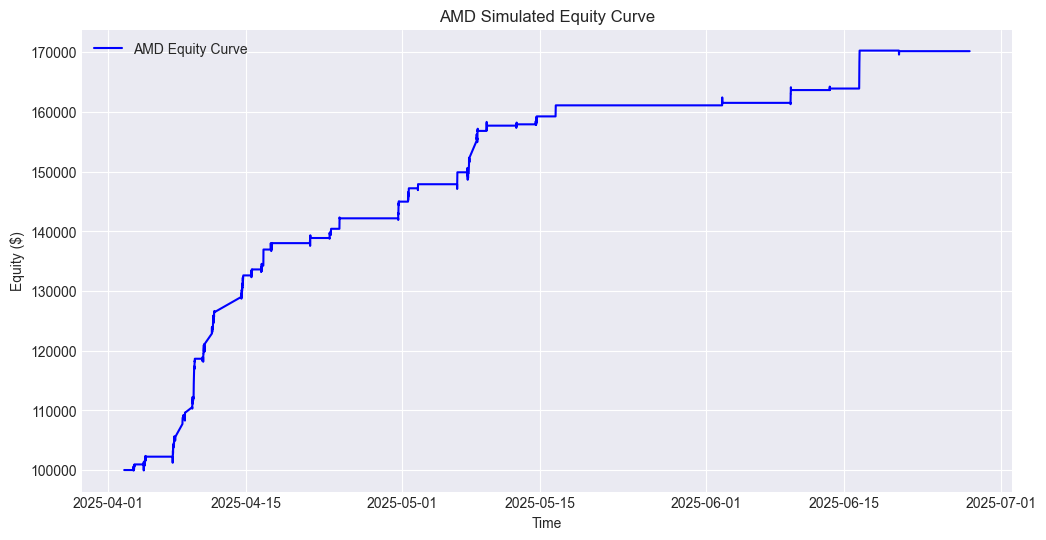

Fetching 5m data for MSFT over the last 60d...
DEBUG: Flattened columns for MSFT. New columns: ['Close', 'High', 'Low', 'Open', 'Volume']

--- DEBUG: prepare_ml_data for unknown_ticker ---
DEBUG: Initial processed_data length: 4679
DEBUG: Initial processed_data columns: ['Close', 'High', 'Low', 'Open', 'Volume']
DEBUG: Calculating SMA_Long...
DEBUG: SMA_Long column created. Has NaNs: True
DEBUG: Calculating SMA_Short...
DEBUG: SMA_Short column created. Has NaNs: True
DEBUG: Calculating RSI...
DEBUG: RSI column created. Has NaNs: True. Length: 4679
DEBUG: Calculating ATR...
DEBUG: ATR column created. Has NaNs: True. Length: 4679
DEBUG: Calculating Target...
DEBUG: Target column created. Has NaNs: False. Length: 4679
DEBUG: All required columns ['RSI', 'SMA_Short', 'SMA_Long', 'ATR', 'Target'] are present before numeric conversion/NaN handling.
DEBUG: Column RSI converted to numeric, inf/NaN replaced. Has NaNs: True
DEBUG: Column SMA_Short converted to numeric, inf/NaN replaced. Has NaNs

C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:187: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_data.loc[:, col].replace([np.inf, -np.inf], np.nan, inplace=True)



--- ML Performance for MSFT (Predicting 6 bars ahead) ---
              precision    recall  f1-score   support

           0       0.48      1.00      0.64       441
           1       0.86      0.01      0.02       491

    accuracy                           0.48       932
   macro avg       0.67      0.50      0.33       932
weighted avg       0.68      0.48      0.32       932



C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:303: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sim_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:313: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

--- Trade Simulation Performance for MSFT ---
Total Trades: 38
Winning Trades: 37
Losing Trades: 1
Win Rate (%): 97.37
Total Profit ($): 18750.76
Final Capital ($): 118750.76
Total Return (%): 18.75
Avg Win ($): 534.31
Avg Loss ($): -1018.85
Reward/Risk Ratio: 0.52


C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:487: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sim_data['Equity_Curve'].fillna(method='ffill', inplace=True)
C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:487: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sim_data['Equity_Curve'].fillna(method='ffill', inplace=True)
C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:488: FutureWarning: A 

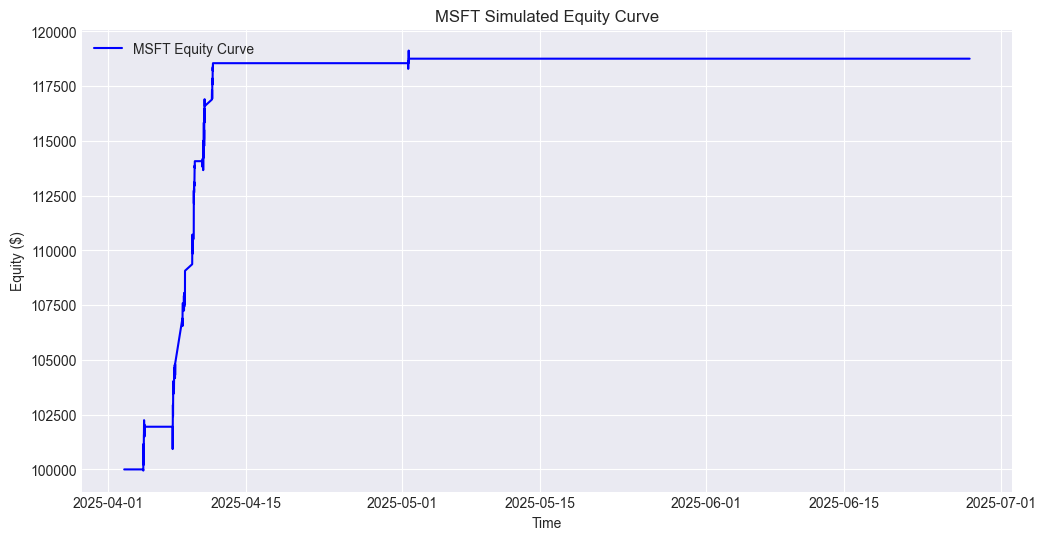

Fetching 5m data for NVDA over the last 60d...
DEBUG: Flattened columns for NVDA. New columns: ['Close', 'High', 'Low', 'Open', 'Volume']

--- DEBUG: prepare_ml_data for unknown_ticker ---
DEBUG: Initial processed_data length: 4678
DEBUG: Initial processed_data columns: ['Close', 'High', 'Low', 'Open', 'Volume']
DEBUG: Calculating SMA_Long...
DEBUG: SMA_Long column created. Has NaNs: True
DEBUG: Calculating SMA_Short...
DEBUG: SMA_Short column created. Has NaNs: True
DEBUG: Calculating RSI...
DEBUG: RSI column created. Has NaNs: True. Length: 4678
DEBUG: Calculating ATR...
DEBUG: ATR column created. Has NaNs: True. Length: 4678
DEBUG: Calculating Target...
DEBUG: Target column created. Has NaNs: False. Length: 4678
DEBUG: All required columns ['RSI', 'SMA_Short', 'SMA_Long', 'ATR', 'Target'] are present before numeric conversion/NaN handling.
DEBUG: Column RSI converted to numeric, inf/NaN replaced. Has NaNs: True
DEBUG: Column SMA_Short converted to numeric, inf/NaN replaced. Has NaNs

C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:187: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_data.loc[:, col].replace([np.inf, -np.inf], np.nan, inplace=True)



--- ML Performance for NVDA (Predicting 6 bars ahead) ---
              precision    recall  f1-score   support

           0       0.53      0.94      0.67       482
           1       0.58      0.10      0.16       450

    accuracy                           0.53       932
   macro avg       0.55      0.52      0.42       932
weighted avg       0.55      0.53      0.43       932



C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:303: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sim_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:313: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

--- Trade Simulation Performance for NVDA ---
Total Trades: 102
Winning Trades: 98
Losing Trades: 4
Win Rate (%): 96.08
Total Profit ($): 44524.32
Final Capital ($): 144524.32
Total Return (%): 44.52
Avg Win ($): 503.73
Avg Loss ($): -1210.42
Reward/Risk Ratio: 0.42


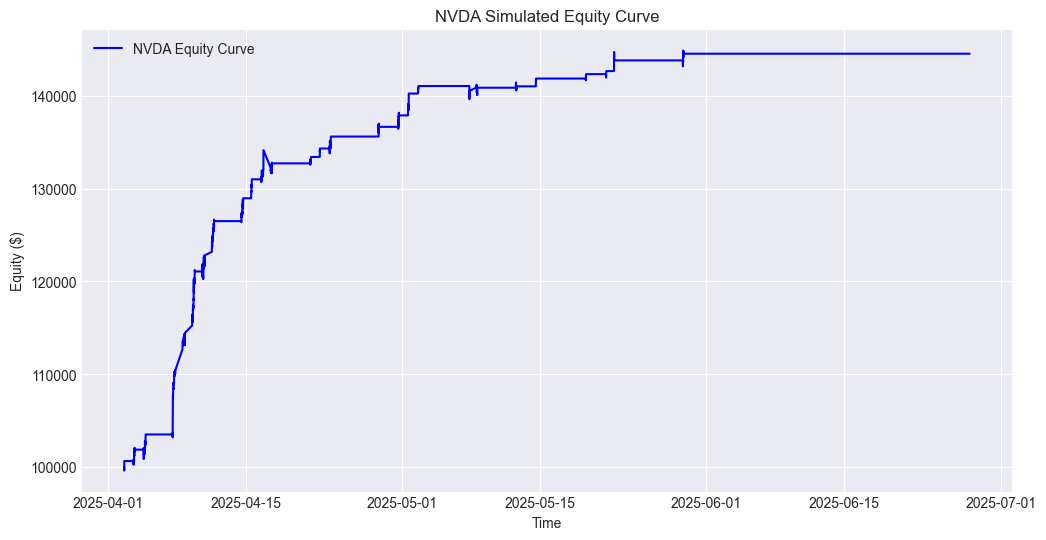

Fetching 5m data for TSM over the last 60d...
DEBUG: Flattened columns for TSM. New columns: ['Close', 'High', 'Low', 'Open', 'Volume']

--- DEBUG: prepare_ml_data for unknown_ticker ---
DEBUG: Initial processed_data length: 4680
DEBUG: Initial processed_data columns: ['Close', 'High', 'Low', 'Open', 'Volume']
DEBUG: Calculating SMA_Long...
DEBUG: SMA_Long column created. Has NaNs: True
DEBUG: Calculating SMA_Short...
DEBUG: SMA_Short column created. Has NaNs: True
DEBUG: Calculating RSI...
DEBUG: RSI column created. Has NaNs: True. Length: 4680
DEBUG: Calculating ATR...
DEBUG: ATR column created. Has NaNs: True. Length: 4680
DEBUG: Calculating Target...
DEBUG: Target column created. Has NaNs: False. Length: 4680
DEBUG: All required columns ['RSI', 'SMA_Short', 'SMA_Long', 'ATR', 'Target'] are present before numeric conversion/NaN handling.
DEBUG: Column RSI converted to numeric, inf/NaN replaced. Has NaNs: True
DEBUG: Column SMA_Short converted to numeric, inf/NaN replaced. Has NaNs: 

C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:187: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_data.loc[:, col].replace([np.inf, -np.inf], np.nan, inplace=True)



--- ML Performance for TSM (Predicting 6 bars ahead) ---
              precision    recall  f1-score   support

           0       0.46      0.08      0.14       462
           1       0.50      0.90      0.64       471

    accuracy                           0.50       933
   macro avg       0.48      0.49      0.39       933
weighted avg       0.48      0.50      0.39       933



C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:303: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sim_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:313: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

--- Trade Simulation Performance for TSM ---
Total Trades: 65
Winning Trades: 63
Losing Trades: 2
Win Rate (%): 96.92
Total Profit ($): 25925.89
Final Capital ($): 125925.89
Total Return (%): 25.93
Avg Win ($): 447.65
Avg Loss ($): -1138.1
Reward/Risk Ratio: 0.39


C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:487: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sim_data['Equity_Curve'].fillna(method='ffill', inplace=True)
C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:487: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sim_data['Equity_Curve'].fillna(method='ffill', inplace=True)
C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2099158066.py:488: FutureWarning: A 

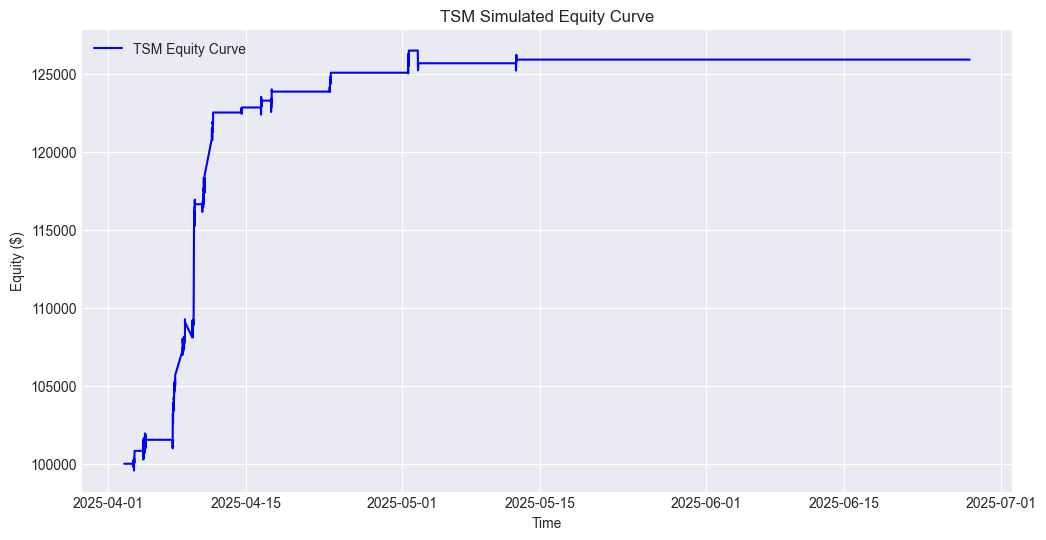


--- OVERALL PORTFOLIO PERFORMANCE (Aggregated Trades) ---
Total Trades: 316
Winning Trades: 305
Losing Trades: 11
Win Rate (%): 96.52
Total Profit ($): 159358.16
Final Capital ($): 559358.16
Total Return (%): 39.84
Avg Win ($): 561.06
Avg Loss ($): -1069.54
Reward/Risk Ratio: 0.52

Note: The 'Overall Portfolio Performance' is a simple aggregation of individual ticker trades.
For a true portfolio simulation, a single equity pool would be managed across all assets,
which is more complex and beyond the 'simple code' scope requested.


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import traceback # Import traceback to get detailed stack info

# Use a professional plot style
if 'seaborn-v0_8-darkgrid' in plt.style.available:
    plt.style.use('seaborn-v0_8-darkgrid')
elif 'seabarn-darkgrid' in plt.style.available:
    plt.style.use('seaborn-darkgrid')
else:
    plt.style.use('ggplot')

# --- PARAMETERS ---
tickers = ["AMD", "MSFT", "NVDA", "TSM"]
capital = 100000
risk_per_trade = 0.01 # Risk 1% of capital per trade

# --- STRATEGY HYPERPARAMETERS ---
sma_period_long = 20
sma_period_short = 5
rsi_period = 7
atr_period = 14
atr_multiplier_stop = 2.0 # Stop Loss distance based on ATR
atr_multiplier_take_profit = 4.0 # Take Profit distance based on ATR
prediction_horizon = 6 # Predict if price will be higher 'prediction_horizon' intervals later.

# --- DATA FETCHING ---
def fetch_data(ticker, interval='5m', period='60d'):
    """Fetches historical stock data for a given ticker."""
    print(f"Fetching {interval} data for {ticker} over the last {period}...")
    # Use auto_adjust=True to get adjusted close prices, good for consistency
    data = yf.download(ticker, interval=interval, period=period, progress=False, auto_adjust=True)
    
    if data.empty:
        print(f"Warning: No data fetched for {ticker}.")
        return pd.DataFrame()
    
    # --- FIX START: Flatten MultiIndex columns if they exist ---
    if isinstance(data.columns, pd.MultiIndex):
        # Join the levels to create single string column names, e.g., 'Close AMD'
        # Or, if only one level is relevant, select that level.
        # Given the debug output, the first level is the OHLCV name, second is ticker.
        # We want 'Close', 'High', 'Low', 'Open', 'Volume'
        data.columns = data.columns.get_level_values(0)
        print(f"DEBUG: Flattened columns for {ticker}. New columns: {data.columns.tolist()}")
    # --- FIX END ---

    # Initial dropna for raw OHLCV, crucial for indicator calculations
    # This also handles cases where yfinance might return NaNs for recent incomplete bars
    data.dropna(inplace=True) 
    data.sort_index(inplace=True) # Ensure chronological order

    # Handle duplicate indices, which can happen with some data sources
    if not data.index.is_unique:
        print(f"Warning: Duplicate indices found for {ticker}. Dropping duplicates.")
        data = data.loc[~data.index.duplicated(keep='first')]

    return data

# --- INDICATOR CALCULATION ---
def calculate_rsi(data, period=14):
    """Calculates the Relative Strength Index (RSI)."""
    if data.empty or 'Close' not in data.columns:
        # print(f"DEBUG RSI: Input data empty or missing 'Close'. len(data)={len(data)}") # Re-enable for further debugging if needed
        return pd.Series(dtype=float, index=data.index)

    # Check for sufficient data for diff()
    if len(data['Close']) < 2:
        # print(f"DEBUG RSI: Not enough data for diff(). len(data['Close'])={len(data['Close'])}") # Re-enable for further debugging if needed
        return pd.Series(dtype=float, index=data.index)

    delta = data['Close'].diff()
    
    # Check if delta is empty, if so, return an empty Series to avoid further issues
    if delta.empty:
        # print("DEBUG RSI: Delta is empty.") # Re-enable for further debugging if needed
        return pd.Series(dtype=float, index=data.index)
    
    gain = delta.where(delta > 0, 0).ewm(com=period - 1, min_periods=period).mean()
    loss = -delta.where(delta < 0, 0).ewm(com=period - 1, min_periods=period).mean()
    
    # Handle division by zero for rs calculation
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = gain / loss
    
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_atr(data, period=14):
    """Calculates the Average True Range (ATR)."""
    if data.empty or not all(col in data.columns for col in ['High', 'Low', 'Close']):
        # print(f"DEBUG ATR: Input data empty or missing HLC. len(data)={len(data)}") # Re-enable for further debugging if needed
        return pd.Series(dtype=float, index=data.index)

    # Check for sufficient data for ATR calculation (needs at least one prior Close for high_close/low_close)
    if len(data) < 2: 
        # print(f"DEBUG ATR: Not enough data for ATR calc. len(data)={len(data)}") # Re-enable for further debugging if needed
        return pd.Series(dtype=float, index=data.index)

    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift(1)) # explicit shift(1) for clarity
    low_close = np.abs(data['Low'] - data['Close'].shift(1))
    
    # Ensure intermediate Series are not empty
    if high_low.empty or high_close.empty or low_close.empty:
        # print("DEBUG ATR: Intermediate ranges are empty.") # Re-enable for further debugging if needed
        return pd.Series(dtype=float, index=data.index)

    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1) 
    
    if true_range.empty:
        # print("DEBUG ATR: True range is empty.") # Re-enable for further debugging if needed
        return pd.Series(dtype=float, index=data.index)

    return true_range.ewm(com=period - 1, min_periods=period).mean()

# --- MACHINE LEARNING TRAINING ---
def prepare_ml_data(data, prediction_horizon):
    """Prepares data for ML model training, addressing look-ahead bias."""
    
    processed_data = data.copy()
    ticker_name = data.name if hasattr(data, 'name') else 'unknown_ticker'
    print(f"\n--- DEBUG: prepare_ml_data for {ticker_name} ---")
    print(f"DEBUG: Initial processed_data length: {len(processed_data)}")
    print(f"DEBUG: Initial processed_data columns: {processed_data.columns.tolist()}")


    # Define minimum data needed to calculate ALL indicators + target
    # This is a critical check to ensure columns will exist
    min_data_for_indicators = max(sma_period_long, atr_period, rsi_period) + prediction_horizon + 1
    if len(processed_data) < min_data_for_indicators:
        raise ValueError(f"Initial data for {ticker_name} is too short ({len(processed_data)} bars) to calculate all indicators and target. Need at least {min_data_for_indicators} bars.")


    # Calculate indicators
    print(f"DEBUG: Calculating SMA_Long...")
    processed_data['SMA_Long'] = processed_data['Close'].rolling(window=sma_period_long).mean()
    print(f"DEBUG: SMA_Long column created. Has NaNs: {processed_data['SMA_Long'].isnull().any()}")
    
    print(f"DEBUG: Calculating SMA_Short...")
    processed_data['SMA_Short'] = processed_data['Close'].rolling(window=sma_period_short).mean()
    print(f"DEBUG: SMA_Short column created. Has NaNs: {processed_data['SMA_Short'].isnull().any()}")

    print(f"DEBUG: Calculating RSI...")
    rsi_series = calculate_rsi(processed_data, rsi_period)
    processed_data['RSI'] = rsi_series
    print(f"DEBUG: RSI column created. Has NaNs: {processed_data['RSI'].isnull().any()}. Length: {len(processed_data['RSI'])}")
    if rsi_series.empty:
        print("DEBUG: calculate_rsi returned an empty series.")

    print(f"DEBUG: Calculating ATR...")
    atr_series = calculate_atr(processed_data, atr_period)
    processed_data['ATR'] = atr_series
    print(f"DEBUG: ATR column created. Has NaNs: {processed_data['ATR'].isnull().any()}. Length: {len(processed_data['ATR'])}")
    if atr_series.empty:
        print("DEBUG: calculate_atr returned an empty series.")


    # Calculate target: 1 if price goes up, 0 otherwise, adjusted for prediction_horizon
    print(f"DEBUG: Calculating Target...")
    processed_data['Target'] = (processed_data['Close'].shift(-prediction_horizon) > processed_data['Close']).astype(float) 
    print(f"DEBUG: Target column created. Has NaNs: {processed_data['Target'].isnull().any()}. Length: {len(processed_data['Target'])}")


    initial_rows = len(processed_data)
    
    # Define columns that MUST be clean and numeric for ML training
    features_and_target_cols = ['RSI', 'SMA_Short', 'SMA_Long', 'ATR', 'Target']

    # CRITICAL: Verify that all these columns actually exist after creation
    missing_cols_after_indicators = [col for col in features_and_target_cols if col not in processed_data.columns]
    if missing_cols_after_indicators:
        raise KeyError(f"Missing required indicator/target columns after calculation for {ticker_name}: {missing_cols_after_indicators}. This suggests an issue with column creation earlier.")

    print(f"DEBUG: All required columns {features_and_target_cols} are present before numeric conversion/NaN handling.")

    # Convert all these critical columns to numeric, coercing errors to NaN
    for col in features_and_target_cols:
        # Explicitly use .loc for setting values to avoid SettingWithCopyWarning
        processed_data.loc[:, col] = pd.to_numeric(processed_data[col], errors='coerce')
        processed_data.loc[:, col].replace([np.inf, -np.inf], np.nan, inplace=True)
        print(f"DEBUG: Column {col} converted to numeric, inf/NaN replaced. Has NaNs: {processed_data[col].isnull().any()}")


    print(f"DEBUG: processed_data length before dropna: {len(processed_data)}")
    print(f"DEBUG: processed_data columns before dropna: {processed_data.columns.tolist()}")
    print(f"DEBUG: Attempting dropna on subset: {features_and_target_cols}")

    # Drop rows where any of the essential ML features or the target are NaN
    processed_data.dropna(subset=features_and_target_cols, inplace=True)
    
    rows_dropped = initial_rows - len(processed_data)
    if rows_dropped > 0:
        print(f"Warning: Dropped {rows_dropped} rows due to NaNs/Infinities after indicator calculation and target creation for ML features for {ticker_name}.")
    
    print(f"DEBUG: processed_data length after dropna: {len(processed_data)}")

    # After dropping NaNs, ensure 'Target' is integer type for classification
    if 'Target' in processed_data.columns and not processed_data['Target'].empty:
        processed_data['Target'] = processed_data['Target'].astype(int)
    else:
        # If target is still empty after cleaning, it's a critical error for ML training
        raise ValueError(f"Target column is empty or invalid after cleaning for {ticker_name}. Cannot train ML model.")

    features = processed_data[['RSI', 'SMA_Short', 'SMA_Long', 'ATR']]
    target = processed_data['Target']

    # Crucial check: Ensure features and target are not empty after all processing
    if features.empty or target.empty:
        raise ValueError(f"Not enough valid data for ML training after cleaning for {ticker_name}. Features or Target DataFrame/Series is empty.")
    
    # Check if any feature column is entirely identical (e.g., all 0s or all same value)
    for col in features.columns:
        if features[col].nunique() <= 1:
            print(f"Warning: Feature '{col}' for {ticker_name} has only one unique value. It might not be useful for training.")
            # Consider dropping such a column if it doesn't provide any signal
            # features = features.drop(columns=[col]) # Uncomment if you want to drop
            
    # Minimum data points required for meaningful training and splitting
    min_required_rows_for_split = max(sma_period_long, atr_period, rsi_period, prediction_horizon) + 10 # Renamed for clarity
    if len(features) < min_required_rows_for_split:
        raise ValueError(f"Not enough data ({len(features)} rows) after indicator calculation and NaN removal for meaningful ML training (need at least {min_required_rows_for_split}).")

    # If the remaining data is too small after all cleaning, train_test_split might fail
    if len(features) < 2: # Need at least 2 samples to split (one for train, one for test)
        raise ValueError(f"Too few samples ({len(features)}) to perform train_test_split after data preparation. Need at least 2.")
    
    # Adjusted test_size if data is small, to ensure at least 1 sample in test set
    test_size_actual = 0.2
    if len(features) * test_size_actual < 1 and len(features) >= 1: # If less than 1 sample for test, make it 1
        test_size_actual = 1 / len(features) # Ensure at least one sample in test set
    elif len(features) * test_size_actual < 1: # If total features < 1, then test_size_actual could be 0, which train_test_split won't like
        raise ValueError(f"Cannot determine a valid test_size for {len(features)} samples. Try increasing data period.")


    return processed_data, *train_test_split(features, target, test_size=test_size_actual, shuffle=False, random_state=42)

# --- TRADE SIMULATION USING ML SIGNALS ---
def simulate_trades(data, clf, ticker_symbol, initial_capital):
    """Simulates trades for a single ticker based on ML signals with realistic exits."""
    trades = []
    equity = initial_capital
    position_active = False
    entry_price = 0
    position_size = 0
    entry_bar_index = -1 
    stop_loss = 0
    take_profit = 0

    sim_data = data.copy()
    
    sim_data['ML_Pred'] = np.nan 
    
    features_cols = ['RSI', 'SMA_Short', 'SMA_Long', 'ATR']
    
    # --- Prediction phase for ML_Pred ---
    if not all(col in sim_data.columns for col in features_cols):
        print(f"Warning: Missing required feature columns for {ticker_symbol} in simulation. Cannot make ML predictions.")
        # If features are missing, ensure sim_data['ML_Pred'] remains NaN or 0 so no trades trigger
        sim_data['ML_Pred'].fillna(0, inplace=True)
    else:
        # Create a temporary DataFrame for prediction where features are numeric and not NaN
        clean_features = sim_data[features_cols].apply(pd.to_numeric, errors='coerce').fillna(0) 
        
        if clean_features.empty:
            print(f"Warning: No valid feature rows for {ticker_symbol} after final clean for prediction. Skipping ML prediction.")
            sim_data['ML_Pred'].fillna(0, inplace=True) # Ensure it's not NaN if clean_features is empty
        else:
            try:
                raw_predictions = clf.predict(clean_features)
                
                # Ensure predictions are a 1D array
                if raw_predictions.ndim > 1:
                    raw_predictions = raw_predictions.flatten()

                ml_predictions_series = pd.Series(raw_predictions, index=clean_features.index, dtype=int) # Should be int (0 or 1)
                sim_data['ML_Pred'] = ml_predictions_series.reindex(sim_data.index)

            except Exception as e:
                print(f"Error during ML prediction for {ticker_symbol}: {e}. Setting ML_Pred to NaN.")
                sim_data['ML_Pred'].fillna(0, inplace=True) # Fallback to 0 if prediction fails

    sim_data['Equity_Curve'] = np.nan 

    # --- CRITICAL PRE-PROCESSING FOR SIMULATION LOOP ---
    # Convert all necessary columns to numeric and fill NaNs to prevent ambiguity errors
    numeric_cols = ['Close', 'High', 'Low', 'ATR', 'ML_Pred']
    for col in numeric_cols:
        if col not in sim_data.columns:
            # If a column is genuinely missing, add it with NaNs and fill 0.
            # This handles cases where ML_Pred might not have been created due to errors.
            print(f"Warning: Missing critical column '{col}' in sim_data for {ticker_symbol}. Adding with NaNs and filling 0.")
            sim_data[col] = np.nan
        # Force numeric conversion, coercing errors to NaN
        sim_data[col] = pd.to_numeric(sim_data[col], errors='coerce')
        # Replace inf/-inf with NaN before filling
        sim_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        
        if col == 'ATR':
            # Fill ATR NaNs with its mean if positive, else a small value
            sim_data[col].fillna(sim_data[col].mean() if sim_data[col].mean() > 0 else 0.001, inplace=True)
            # Ensure no zeros remain in ATR which would cause division by zero
            sim_data[col].replace(0, sim_data[col].mean() if sim_data[col].mean() > 0 else 0.001, inplace=True)
            # Final check to ensure ATR is always positive
            sim_data[col] = sim_data[col].apply(lambda x: x if x > 0 else 0.001)
        else:
            sim_data[col].fillna(0, inplace=True) 

    # Determine a typical interval duration for time-based exits/plotting
    interval_duration_seconds = 0
    if len(sim_data.index) > 1:
        try:
            # Access DatetimeIndex elements directly using []
            interval_duration_seconds = (sim_data.index[1] - sim_data.index[0]).total_seconds()
            if interval_duration_seconds <= 0:
                 print(f"Warning: Interval duration for {ticker_symbol} is zero or negative. Using default 5 minutes (300s).")
                 interval_duration_seconds = 5 * 60 
        except IndexError: 
            print(f"Warning: Could not determine interval duration for {ticker_symbol} (IndexError). Using default 5 minutes (300s).")
            interval_duration_seconds = 5 * 60 
    else: 
        print(f"Warning: Data for {ticker_symbol} is too short to determine interval duration ({len(sim_data.index)} bars). Using default 5 minutes (300s).")
        interval_duration_seconds = 5 * 60

    # Ensure enough data for simulation after cleaning
    min_sim_bars = max(sma_period_long, atr_period, rsi_period) + prediction_horizon + 1 
    if len(sim_data) < min_sim_bars:
        print(f"Not enough data for {ticker_symbol} to run simulation loop (have {len(sim_data)} bars, need at least {min_sim_bars}).")
        if not sim_data.empty:
            sim_data['Equity_Curve'].iloc[0] = equity
        return sim_data, trades, equity

    for i in range(len(sim_data)): # Iterate through all bars
        try:
            # All these values are now guaranteed to be scalars (float/int) thanks to pre-processing
            current_close_val = sim_data['Close'].iloc[i]
            current_high_val = sim_data['High'].iloc[i]
            current_low_val = sim_data['Low'].iloc[i]
            current_atr_val = sim_data['ATR'].iloc[i]
            ml_prediction_val = int(sim_data['ML_Pred'].iloc[i]) # Will be 0 or 1 because of fillna(0)

            # Basic sanity check for prices
            if current_close_val <= 0 or current_high_val <=0 or current_low_val <=0:
                sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity
                continue # Skip this bar if price is invalid
            
            # Defensive check for ATR being non-positive for division
            if current_atr_val <= 0: 
                sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity
                continue # Skip this bar as ATR is invalid for calculations

            # --- Trade Management Logic ---
            if position_active:
                # Check for Stop Loss hit (Long position, if current low hits SL)
                if current_low_val <= stop_loss:
                    pnl = (stop_loss - entry_price) * position_size 
                    equity += pnl
                    trades.append({
                        'ticker': ticker_symbol,
                        'entry_time': sim_data.index[entry_bar_index],
                        'exit_time': sim_data.index[i],
                        'entry_price': entry_price,
                        'exit_price': stop_loss, 
                        'position_size': position_size,
                        'pnl': pnl,
                        'exit_reason': 'Stop Loss'
                    })
                    position_active = False
                    entry_bar_index = -1 
                
                # Check for Take Profit hit (Long position, if current high hits TP)
                elif current_high_val >= take_profit:
                    pnl = (take_profit - entry_price) * position_size 
                    equity += pnl
                    trades.append({
                        'ticker': ticker_symbol,
                        'entry_time': sim_data.index[entry_bar_index],
                        'exit_time': sim_data.index[i],
                        'entry_price': entry_price,
                        'exit_price': take_profit, 
                        'position_size': position_size,
                        'pnl': pnl,
                        'exit_reason': 'Take Profit'
                    })
                    position_active = False
                    entry_bar_index = -1
                
                # Check for Time-based Exit (if held for prediction_horizon bars without hitting SL/TP)
                elif (i - entry_bar_index) >= prediction_horizon:
                    pnl = (current_close_val - entry_price) * position_size 
                    equity += pnl
                    trades.append({
                        'ticker': ticker_symbol,
                        'entry_time': sim_data.index[entry_bar_index],
                        'exit_time': sim_data.index[i],
                        'entry_price': entry_price,
                        'exit_price': current_close_val, 
                        'position_size': position_size,
                        'pnl': pnl,
                        'exit_reason': 'Time Horizon'
                    })
                    position_active = False
                    entry_bar_index = -1
                
                # If position is still active after checks, update equity curve (unrealized PnL)
                if position_active: 
                    unrealized_pnl = (current_close_val - entry_price) * position_size
                    # Sum of realized PnL from previous trades + unrealized PnL of current trade
                    current_realized_pnl_sum = sum(t['pnl'] for t in trades)
                    sim_data.loc[sim_data.index[i], 'Equity_Curve'] = initial_capital + current_realized_pnl_sum + unrealized_pnl
                else: 
                    # Position closed in this bar, equity already updated
                    sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity


            else: # No position active - check for entry
                if ml_prediction_val == 1: # ML predicts 'up'
                    entry_price = current_close_val
                    
                    # Recalculate SL/TP using the latest ATR
                    stop_loss = entry_price - current_atr_val * atr_multiplier_stop
                    take_profit = entry_price + current_atr_val * atr_multiplier_take_profit

                    # Calculate position size based on risk per trade
                    # Ensure current_atr_val * atr_multiplier_stop is not zero for division
                    risk_amount = equity * risk_per_trade
                    stop_loss_distance = current_atr_val * atr_multiplier_stop
                    
                    if stop_loss_distance <= 0: # Defensive check
                        sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity
                        continue

                    raw_size = risk_amount / stop_loss_distance
                    position_size = int(raw_size) 
                    
                    # Ensure at least 1 share if raw_size is between 0 and 1
                    if position_size == 0 and raw_size > 0:
                        position_size = 1 
                    
                    # Ensure we have enough capital for the position
                    if position_size > 0 and (position_size * entry_price) <= equity:
                        position_active = True
                        entry_bar_index = i 
                        # Log equity at the point of entry (current equity before this trade's potential PnL)
                        sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity 
                    else:
                        # Not enough capital or position_size is zero, no trade
                        sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity
                        continue 
                else:
                    # No entry signal
                    sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity

        except Exception as e:
            print(f"!!! Error within simulation loop for {ticker_symbol} at bar index {i}: {e} !!!")
            traceback.print_exc() 
            sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity # Try to log equity before continuing
            continue 

    # Close any remaining active position at the last available price
    if position_active and entry_bar_index != -1:
        last_valid_index = len(sim_data) - 1
        # Ensure we don't try to access an index out of bounds
        if last_valid_index >= entry_bar_index and last_valid_index < len(sim_data):
            exit_price = sim_data['Close'].iloc[last_valid_index]
            pnl = (exit_price - entry_price) * position_size
            equity += pnl
            trades.append({
                'ticker': ticker_symbol,
                'entry_time': sim_data.index[entry_bar_index],
                'exit_time': sim_data.index[last_valid_index],
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position_size': position_size,
                'pnl': pnl,
                'exit_reason': 'Last Bar Close'
            })
            sim_data.loc[sim_data.index[last_valid_index], 'Equity_Curve'] = equity 
    
    # Fill any remaining NaNs in Equity_Curve with the last known equity value
    sim_data['Equity_Curve'].fillna(method='ffill', inplace=True)
    sim_data['Equity_Curve'].fillna(method='bfill', inplace=True) # For any leading NaNs if ffill didn't cover

    return sim_data, trades, equity

# --- PERFORMANCE METRICS ---
def compute_performance(trades, initial_capital):
    """Computes comprehensive performance metrics for a list of trades."""
    if not trades:
        return {'Message': 'No trades executed.'}

    pnl_list = [t['pnl'] for t in trades]
    wins = [p for p in pnl_list if p > 0]
    losses = [p for p in pnl_list if p <= 0]
    
    total_profit_loss = sum(pnl_list)
    final_capital = initial_capital + total_profit_loss

    avg_win = np.mean(wins) if wins else 0
    avg_loss = np.mean(losses) if losses else 0
    
    rr = abs(avg_win / avg_loss) if avg_loss != 0 else np.inf
    win_rate = len(wins) / len(pnl_list) * 100 if pnl_list else 0

    total_return_pct = (total_profit_loss / initial_capital) * 100

    return {
        'Total Trades': len(pnl_list),
        'Winning Trades': len(wins),
        'Losing Trades': len(losses),
        'Win Rate (%)': round(win_rate, 2),
        'Total Profit ($)': round(total_profit_loss, 2),
        'Final Capital ($)': round(final_capital, 2),
        'Total Return (%)': round(total_return_pct, 2),
        'Avg Win ($)': round(avg_win, 2),
        'Avg Loss ($)': round(avg_loss, 2),
        'Reward/Risk Ratio': round(rr, 2)
    }

# --- MAIN EXECUTION BLOCK ---
if __name__ == "__main__":
    all_trades = []
    initial_portfolio_equity = capital
    
    for ticker in tickers:
        data = fetch_data(ticker)
        # Give the data a 'name' attribute for better error messages
        data.name = ticker 
        if not data.empty:
            try:
                data_with_indicators, X_train, X_test, y_train, y_test = prepare_ml_data(data.copy(), prediction_horizon)
                
                # Check if training data is valid before fitting
                if X_train.empty or y_train.empty:
                    print(f"Skipping ML training for {ticker}: X_train or y_train is empty after preparation.")
                    continue
                if len(X_train) != len(y_train):
                    print(f"Skipping ML training for {ticker}: Mismatch in length between X_train ({len(X_train)}) and y_train ({len(y_train)}).")
                    continue

                clf = RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt')
                clf.fit(X_train, y_train)
                
                # Only predict if X_test is not empty
                if not X_test.empty:
                    y_pred = clf.predict(X_test)
                    print(f"\n--- ML Performance for {ticker} (Predicting {prediction_horizon} bars ahead) ---")
                    print(classification_report(y_test, y_pred))
                else:
                    print(f"\n--- ML Performance for {ticker} ---")
                    print("No test data available for classification report.")


                try:
                    sim_data, ticker_trades, final_ticker_equity = simulate_trades(data_with_indicators, clf, ticker, initial_portfolio_equity)
                    
                    if ticker_trades: 
                        all_trades.extend(ticker_trades)

                    print(f"--- Trade Simulation Performance for {ticker} ---")
                    ticker_stats = compute_performance(ticker_trades, initial_portfolio_equity)
                    for k, v in ticker_stats.items():
                        print(f"{k}: {v}")
                    
                    if not sim_data['Equity_Curve'].dropna().empty:
                        plt.figure(figsize=(12, 6))
                        plt.plot(sim_data['Equity_Curve'].dropna(), label=f'{ticker} Equity Curve', color='blue')
                        plt.title(f'{ticker} Simulated Equity Curve')
                        plt.xlabel('Time')
                        plt.ylabel('Equity ($)')
                        plt.grid(True)
                        plt.legend()
                        plt.show()
                    else:
                        print(f"No equity curve data to plot for {ticker} or it's entirely NaN after simulation.")

                except Exception as sim_e:
                    print(f"\n!!! CRITICAL SIMULATION ERROR for {ticker}: {sim_e} !!!")
                    print("Full traceback for simulation error:")
                    traceback.print_exc() 
                    print(f"Skipping trade simulation for {ticker} due to critical error.")

            except ValueError as ve:
                print(f"Error for {ticker} during ML preparation/training: {ve}")
                traceback.print_exc() # Print full traceback for this error
            except Exception as e:
                print(f"An unexpected error occurred for {ticker} during overall processing: {e}")
                traceback.print_exc()
        else:
            print(f"Skipping ML training for {ticker} due to no data.")

    print("\n" + "="*50)
    print("--- OVERALL PORTFOLIO PERFORMANCE (Aggregated Trades) ---")
    print("="*50)
    
    # Calculate initial overall capital more robustly
    if all_trades:
        simulated_tickers_count = len(set(trade['ticker'] for trade in all_trades)) 
        adjusted_initial_overall_capital = initial_portfolio_equity * simulated_tickers_count 
    else:
        adjusted_initial_overall_capital = initial_portfolio_equity # If no trades, use the base capital for reporting

    overall_stats = compute_performance(all_trades, adjusted_initial_overall_capital) 
    
    for k, v in overall_stats.items():
        print(f"{k}: {v}")

    print("\nNote: The 'Overall Portfolio Performance' is a simple aggregation of individual ticker trades.")
    print("For a true portfolio simulation, a single equity pool would be managed across all assets,")
    print("which is more complex and beyond the 'simple code' scope requested.")

Optimising with grid search to get better results on one ticker only to reduce time 


===== Processing AMD =====
Fetching 5m data for AMD over the last 60d...
DEBUG: Flattened columns for AMD. New columns: ['Close', 'High', 'Low', 'Open', 'Volume']

--- Running GridSearchCV for RandomForestClassifier for AMD ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2996063341.py:150: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_data.loc[:, col].replace([np.inf, -np.inf], np.nan, inplace=True)


Best RandomForest Parameters for AMD: {'max_depth': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy for AMD: 0.4902
Test Set Accuracy for AMD: 0.5290

--- ML Performance for AMD (Predicting 6 bars ahead) ---
              precision    recall  f1-score   support

         0.0       0.53      0.81      0.64       479
         1.0       0.54      0.23      0.32       453

    accuracy                           0.53       932
   macro avg       0.53      0.52      0.48       932
weighted avg       0.53      0.53      0.49       932


--- Running Trade Simulation for AMD with best ML model ---


C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2996063341.py:239: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sim_data.loc[:, col].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Prachi\AppData\Local\Temp\ipykernel_20152\2996063341.py:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

--- Trade Simulation Performance for AMD ---
Total Trades: 97
Winning Trades: 68
Losing Trades: 29
Win Rate (%): 70.1
Total Profit ($): 38941.07
Final Capital ($): 138941.07
Total Return (%): 38.94
Avg Win ($): 848.51
Avg Loss ($): -646.81
Reward/Risk Ratio: 1.31


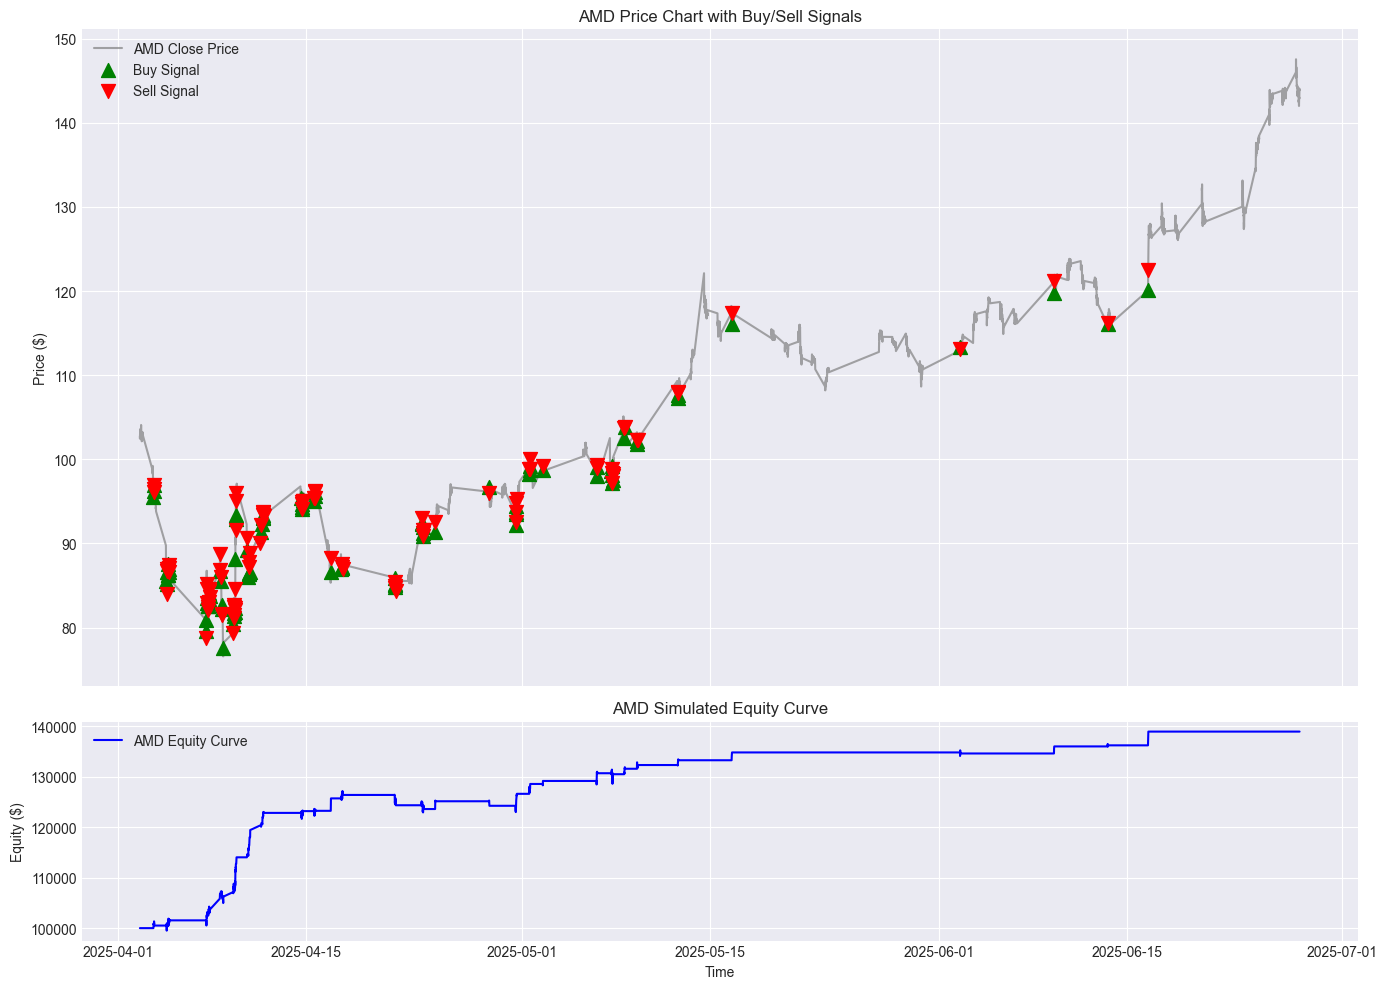


--- OVERALL PORTFOLIO PERFORMANCE (Aggregated Trades from Best Models) ---
Total Trades: 97
Winning Trades: 68
Losing Trades: 29
Win Rate (%): 70.1
Total Profit ($): 38941.07
Final Capital ($): 138941.07
Total Return (%): 38.94
Avg Win ($): 848.51
Avg Loss ($): -646.81
Reward/Risk Ratio: 1.31

Note: The 'Overall Portfolio Performance' is a simple aggregation of individual ticker trades.
For a true portfolio simulation, a single equity pool would be managed across all assets,
which is more complex and beyond the 'simple code' scope requested.


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import traceback

# Use a professional plot style
if 'seaborn-v0_8-darkgrid' in plt.style.available:
    plt.style.use('seaborn-v0_8-darkgrid')
elif 'seaborn-darkgrid' in plt.style.available:
    plt.style.use('seaborn-darkgrid')
else:
    plt.style.use('ggplot')

# --- PARAMETERS ---
tickers = ["AMD"] # Using only one ticker for focused optimization demonstration
capital = 100000 # Capital per ticker if running independently
overall_initial_portfolio_capital = capital * len(tickers) # Total capital for overall performance

risk_per_trade = 0.01 # Risk 1% of capital per trade

# --- STRATEGY HYPERPARAMETERS (These will be optimized) ---
# Default values for initial data preparation
sma_period_long = 20
sma_period_short = 5
rsi_period = 7
atr_period = 14
prediction_horizon = 6

# Define parameter grids for GridSearchCV
# RandomForest parameters
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10]
}

atr_multiplier_stop = 2.0
atr_multiplier_take_profit = 4.0


# --- DATA FETCHING ---
def fetch_data(ticker, interval='5m', period='60d'):
    """Fetches historical stock data for a given ticker."""
    print(f"Fetching {interval} data for {ticker} over the last {period}...")
    data = yf.download(ticker, interval=interval, period=period, progress=False, auto_adjust=True)
    
    if data.empty:
        print(f"Warning: No data fetched for {ticker}.")
        return pd.DataFrame()
    
    # --- FIX: Flatten MultiIndex columns if they exist ---
    if isinstance(data.columns, pd.MultiIndex):
        # We assume the first level is the OHLCV name (Close, High, etc.)
        data.columns = data.columns.get_level_values(0)
        print(f"DEBUG: Flattened columns for {ticker}. New columns: {data.columns.tolist()}")
    
    # Ensure standard OHLCV columns exist after flattening
    required_ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    if not all(col in data.columns for col in required_ohlcv_cols):
        print(f"Error: Missing one or more required OHLCV columns after fetching for {ticker}.")
        return pd.DataFrame() # Return empty if essential columns are missing

    data.dropna(inplace=True) 
    data.sort_index(inplace=True)

    if not data.index.is_unique:
        print(f"Warning: Duplicate indices found for {ticker}. Dropping duplicates.")
        data = data.loc[~data.index.duplicated(keep='first')]
    
    if data.empty:
        print(f"Warning: Data became empty after dropping NaNs or duplicates for {ticker}.")

    return data

# --- INDICATOR CALCULATION ---
def calculate_rsi(data, period=14):
    """Calculates the Relative Strength Index (RSI)."""
    if data.empty or 'Close' not in data.columns:
        return pd.Series(dtype=float, index=data.index)
    if len(data['Close']) < period + 1:
        return pd.Series(dtype=float, index=data.index)

    delta = data['Close'].diff()
    if delta.empty: return pd.Series(dtype=float, index=data.index)
    
    gain = delta.where(delta > 0, 0).ewm(com=period - 1, min_periods=period).mean()
    loss = -delta.where(delta < 0, 0).ewm(com=period - 1, min_periods=period).mean()
    
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = gain / loss
    
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_atr(data, period=14):
    """Calculates the Average True Range (ATR)."""
    if data.empty or not all(col in data.columns for col in ['High', 'Low', 'Close']):
        return pd.Series(dtype=float, index=data.index)
    if len(data) < period + 1:
        return pd.Series(dtype=float, index=data.index)

    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift(1))
    low_close = np.abs(data['Low'] - data['Close'].shift(1))
    
    if high_low.empty or high_close.empty or low_close.empty:
        return pd.Series(dtype=float, index=data.index)

    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1) 
    
    if true_range.empty:
        return pd.Series(dtype=float, index=data.index)

    return true_range.ewm(com=period - 1, min_periods=period).mean()

# --- MACHINE LEARNING TRAINING ---
def prepare_ml_data(data, prediction_horizon, sma_long_p, sma_short_p, rsi_p, atr_p):
    """
    Prepares data for ML model training, addressing look-ahead bias.
    Now accepts indicator periods as arguments.
    """
    processed_data = data.copy()
    ticker_name = data.name if hasattr(data, 'name') else 'unknown_ticker'
    
    min_data_for_indicators = max(sma_long_p, atr_p, rsi_p) + prediction_horizon + 1 
    if len(processed_data) < min_data_for_indicators:
        raise ValueError(f"Initial data for {ticker_name} is too short ({len(processed_data)} bars) to calculate all indicators and target. Need at least {min_data_for_indicators} bars.")

    processed_data.loc[:, 'SMA_Long'] = processed_data['Close'].rolling(window=sma_long_p).mean()
    processed_data.loc[:, 'SMA_Short'] = processed_data['Close'].rolling(window=sma_short_p).mean()
    processed_data.loc[:, 'RSI'] = calculate_rsi(processed_data, rsi_p)
    processed_data.loc[:, 'ATR'] = calculate_atr(processed_data, atr_p)

    processed_data.loc[:, 'Target'] = (processed_data['Close'].shift(-prediction_horizon) > processed_data['Close']).astype(float) 

    initial_rows = len(processed_data)
    
    features_and_target_cols = ['RSI', 'SMA_Short', 'SMA_Long', 'ATR', 'Target']

    missing_cols_after_indicators = [col for col in features_and_target_cols if col not in processed_data.columns]
    if missing_cols_after_indicators:
        raise KeyError(f"Missing required indicator/target columns after calculation for {ticker_name}: {missing_cols_after_indicators}. This suggests an issue with column creation earlier.")

    for col in features_and_target_cols:
        processed_data.loc[:, col] = pd.to_numeric(processed_data[col], errors='coerce')
        processed_data.loc[:, col].replace([np.inf, -np.inf], np.nan, inplace=True)

    processed_data.dropna(subset=features_and_target_cols, inplace=True)
    
    rows_dropped = initial_rows - len(processed_data)
    if rows_dropped > 0:
        print(f"Warning: Dropped {rows_dropped} rows due to NaNs/Infinities after indicator calculation and target creation for ML features for {ticker_name}.")

    if 'Target' in processed_data.columns and not processed_data['Target'].empty:
        processed_data.loc[:, 'Target'] = processed_data['Target'].astype(int)
    else:
        raise ValueError(f"Target column is empty or invalid after cleaning for {ticker_name}. Cannot train ML model.")

    features = processed_data[['RSI', 'SMA_Short', 'SMA_Long', 'ATR']]
    target = processed_data['Target']

    if features.empty or target.empty:
        raise ValueError(f"Not enough valid data for ML training after cleaning for {ticker_name}. Features or Target DataFrame/Series is empty.")
    
    for col in features.columns:
        if features[col].nunique() <= 1:
            print(f"Warning: Feature '{col}' for {ticker_name} has only one unique value. It might not be useful for training.")
            
    min_required_rows_for_split = max(sma_long_p, atr_p, rsi_p, prediction_horizon) + 10 
    if len(features) < min_required_rows_for_split:
        raise ValueError(f"Not enough data ({len(features)} rows) after indicator calculation and NaN removal for meaningful ML training (need at least {min_required_rows_for_split}).")

    if len(features) < 2:
        raise ValueError(f"Too few samples ({len(features)}) to perform train_test_split after data preparation. Need at least 2.")
    
    test_size_actual = 0.2
    if len(features) * test_size_actual < 1 and len(features) >= 1:
        test_size_actual = 1 / len(features)
    elif len(features) * test_size_actual < 1:
        raise ValueError(f"Cannot determine a valid test_size for {len(features)} samples. Try increasing data period.")

    return processed_data, *train_test_split(features, target, test_size=test_size_actual, shuffle=False, random_state=42)

# --- TRADE SIMULATION USING ML SIGNALS ---
def simulate_trades(data, clf, ticker_symbol, initial_capital, atr_stop_mult, atr_tp_mult):
    """
    Simulates trades for a single ticker based on ML signals with realistic exits.
    Accepts ATR multipliers as arguments.
    """
    trades = []
    equity = initial_capital
    position_active = False
    entry_price = 0
    position_size = 0
    entry_bar_index = -1 
    stop_loss = 0
    take_profit = 0

    sim_data = data.copy()
    sim_data.loc[:, 'ML_Pred'] = np.nan 
    sim_data.loc[:, 'Buy_Signal'] = np.nan # New column for buy signals
    sim_data.loc[:, 'Sell_Signal'] = np.nan # New column for sell signals (exits)
    
    features_cols = ['RSI', 'SMA_Short', 'SMA_Long', 'ATR']
    
    if not all(col in sim_data.columns for col in features_cols):
        print(f"Warning: Missing required feature columns for {ticker_symbol} in simulation. Cannot make ML predictions.")
        sim_data.loc[:, 'ML_Pred'] = 0 # Ensure it's not NaN if features are missing
    else:
        clean_features = sim_data[features_cols].apply(pd.to_numeric, errors='coerce').fillna(0) 
        
        if clean_features.empty:
            print(f"Warning: No valid feature rows for {ticker_symbol} after final clean for prediction. Skipping ML prediction.")
            sim_data.loc[:, 'ML_Pred'] = 0
        else:
            try:
                raw_predictions = clf.predict(clean_features)
                if raw_predictions.ndim > 1:
                    raw_predictions = raw_predictions.flatten()
                
                ml_predictions_series = pd.Series(raw_predictions, index=clean_features.index, dtype=int)
                sim_data.loc[:, 'ML_Pred'] = ml_predictions_series.reindex(sim_data.index).fillna(0)
            except Exception as e:
                print(f"Error during ML prediction for {ticker_symbol}: {e}. Setting ML_Pred to 0.")
                sim_data.loc[:, 'ML_Pred'] = 0 

    sim_data.loc[:, 'Equity_Curve'] = np.nan 

    numeric_cols = ['Close', 'High', 'Low', 'ATR', 'ML_Pred']
    for col in numeric_cols:
        if col not in sim_data.columns:
            print(f"Warning: Missing critical column '{col}' in sim_data for {ticker_symbol}. Adding with NaNs and filling 0.")
            sim_data.loc[:, col] = np.nan
        sim_data.loc[:, col] = pd.to_numeric(sim_data[col], errors='coerce')
        sim_data.loc[:, col].replace([np.inf, -np.inf], np.nan, inplace=True)
        
        if col == 'ATR':
            sim_data.loc[:, col].fillna(sim_data[col].mean() if sim_data[col].mean() > 0 else 0.001, inplace=True)
            sim_data.loc[:, col].replace(0, sim_data[col].mean() if sim_data[col].mean() > 0 else 0.001, inplace=True)
            sim_data.loc[:, col] = sim_data[col].apply(lambda x: x if x > 0 else 0.001)
        else:
            sim_data.loc[:, col].fillna(0, inplace=True) 

    # Determine interval duration
    if len(sim_data.index) > 1:
        interval_duration_seconds = (sim_data.index[1] - sim_data.index[0]).total_seconds() 
        if interval_duration_seconds <= 0: interval_duration_seconds = 5 * 60 
    else: interval_duration_seconds = 5 * 60

    min_sim_bars = max(sma_period_long, atr_period, rsi_period) + prediction_horizon + 1 
    if len(sim_data) < min_sim_bars:
        print(f"Not enough data for {ticker_symbol} to run simulation loop (have {len(sim_data)} bars, need at least {min_sim_bars}).")
        if not sim_data.empty: sim_data.loc[sim_data.index[0], 'Equity_Curve'] = equity
        return sim_data, trades, equity

    for i in range(len(sim_data)):
        try:
            current_close_val = sim_data['Close'].iloc[i]
            current_high_val = sim_data['High'].iloc[i]
            current_low_val = sim_data['Low'].iloc[i]
            current_atr_val = sim_data['ATR'].iloc[i]
            ml_prediction_val = int(sim_data['ML_Pred'].iloc[i])

            if current_close_val <= 0 or current_high_val <=0 or current_low_val <=0:
                sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity
                continue
            
            if current_atr_val <= 0: 
                sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity
                continue

            if position_active:
                exit_reason = None
                exit_price_actual = 0

                if current_low_val <= stop_loss:
                    exit_price_actual = stop_loss
                    exit_reason = 'Stop Loss'
                
                elif current_high_val >= take_profit:
                    exit_price_actual = take_profit
                    exit_reason = 'Take Profit'
                
                elif (i - entry_bar_index) >= prediction_horizon:
                    exit_price_actual = current_close_val
                    exit_reason = 'Time Horizon'
                
                if exit_reason:
                    pnl = (exit_price_actual - entry_price) * position_size 
                    equity += pnl
                    trades.append({
                        'ticker': ticker_symbol, 'entry_time': sim_data.index[entry_bar_index], 'exit_time': sim_data.index[i],
                        'entry_price': entry_price, 'exit_price': exit_price_actual, 'position_size': position_size, 'pnl': pnl,
                        'exit_reason': exit_reason
                    })
                    sim_data.loc[sim_data.index[i], 'Sell_Signal'] = exit_price_actual # Mark sell signal
                    position_active = False
                    entry_bar_index = -1 
                
                if position_active: 
                    unrealized_pnl = (current_close_val - entry_price) * position_size
                    current_realized_pnl_sum = sum(t['pnl'] for t in trades)
                    sim_data.loc[sim_data.index[i], 'Equity_Curve'] = initial_capital + current_realized_pnl_sum + unrealized_pnl
                else: 
                    sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity
            else: # No position active - check for entry
                if ml_prediction_val == 1:
                    entry_price = current_close_val
                    
                    stop_loss = entry_price - current_atr_val * atr_stop_mult
                    take_profit = entry_price + current_atr_val * atr_tp_mult

                    risk_amount = equity * risk_per_trade
                    stop_loss_distance = current_atr_val * atr_stop_mult
                    
                    if stop_loss_distance <= 0: continue

                    raw_size = risk_amount / stop_loss_distance
                    position_size = int(raw_size) 
                    
                    if position_size == 0 and raw_size > 0: position_size = 1 
                    
                    if position_size > 0 and (position_size * entry_price) <= equity:
                        position_active = True
                        entry_bar_index = i 
                        sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity
                        sim_data.loc[sim_data.index[i], 'Buy_Signal'] = entry_price # Mark buy signal
                    else:
                        sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity
                        continue 
                else:
                    sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity

        except Exception as e:
            print(f"!!! Error within simulation loop for {ticker_symbol} at bar index {i}: {e} !!!")
            traceback.print_exc() 
            sim_data.loc[sim_data.index[i], 'Equity_Curve'] = equity
            continue 

    if position_active and entry_bar_index != -1:
        last_valid_index = len(sim_data) - 1
        if last_valid_index >= entry_bar_index and last_valid_index < len(sim_data):
            exit_price = sim_data['Close'].iloc[last_valid_index]
            pnl = (exit_price - entry_price) * position_size
            equity += pnl
            trades.append({
                'ticker': ticker_symbol, 'entry_time': sim_data.index[entry_bar_index], 'exit_time': sim_data.index[last_valid_index],
                'entry_price': entry_price, 'exit_price': exit_price, 'position_size': position_size, 'pnl': pnl,
                'exit_reason': 'Last Bar Close'
            })
            sim_data.loc[sim_data.index[last_valid_index], 'Sell_Signal'] = exit_price # Mark last sell signal
            sim_data.loc[sim_data.index[last_valid_index], 'Equity_Curve'] = equity 
    
    sim_data['Equity_Curve'].fillna(method='ffill', inplace=True)
    sim_data['Equity_Curve'].fillna(method='bfill', inplace=True)

    return sim_data, trades, equity

# --- PERFORMANCE METRICS ---
def compute_performance(trades, initial_capital):
    """Computes comprehensive performance metrics for a list of trades."""
    if not trades:
        return {'Message': 'No trades executed.', 'Total Profit ($)': 0, 'Total Return (%)': 0, 'Final Capital ($)': initial_capital}

    pnl_list = [t['pnl'] for t in trades]
    wins = [p for p in pnl_list if p > 0]
    losses = [p for p in pnl_list if p <= 0]
    
    total_profit_loss = sum(pnl_list)
    final_capital = initial_capital + total_profit_loss

    avg_win = np.mean(wins) if wins else 0
    avg_loss = np.mean(losses) if losses else 0
    
    rr = abs(avg_win / avg_loss) if avg_loss != 0 else np.inf
    win_rate = len(wins) / len(pnl_list) * 100 if pnl_list else 0

    total_return_pct = (total_profit_loss / initial_capital) * 100 if initial_capital > 0 else 0

    return {
        'Total Trades': len(pnl_list),
        'Winning Trades': len(wins),
        'Losing Trades': len(losses),
        'Win Rate (%)': round(win_rate, 2),
        'Total Profit ($)': round(total_profit_loss, 2),
        'Final Capital ($)': round(final_capital, 2),
        'Total Return (%)': round(total_return_pct, 2),
        'Avg Win ($)': round(avg_win, 2),
        'Avg Loss ($)': round(avg_loss, 2),
        'Reward/Risk Ratio': round(rr, 2)
    }

# --- MAIN EXECUTION BLOCK ---
if __name__ == "__main__":
    all_trades_from_best_models = []
    all_ticker_sim_data = {} # To store sim_data for plotting later

    for ticker in tickers:
        print(f"\n===== Processing {ticker} =====")
        data = fetch_data(ticker, period='60d') 
        data.name = ticker 

        if not data.empty:
            try:
                data_with_indicators, X_train, X_test, y_train, y_test = \
                    prepare_ml_data(data.copy(), prediction_horizon, sma_period_long, sma_period_short, rsi_period, atr_period)
                
                if X_train.empty or y_train.empty:
                    print(f"Skipping ML training for {ticker}: X_train or y_train is empty after preparation.")
                    continue
                if len(X_train) != len(y_train):
                    print(f"Skipping ML training for {ticker}: Mismatch in length between X_train ({len(X_train)}) and y_train ({len(y_train)}).")
                    continue

                print(f"\n--- Running GridSearchCV for RandomForestClassifier for {ticker} ---")
                rf_clf = RandomForestClassifier(random_state=42)
                grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
                
                if not X_train.empty:
                    grid_search.fit(X_train, y_train)
                    best_clf = grid_search.best_estimator_
                    print(f"Best RandomForest Parameters for {ticker}: {grid_search.best_params_}")
                    print(f"Best Cross-Validation Accuracy for {ticker}: {grid_search.best_score_:.4f}")

                    if not X_test.empty:
                        y_pred = best_clf.predict(X_test)
                        test_accuracy = accuracy_score(y_test, y_pred)
                        print(f"Test Set Accuracy for {ticker}: {test_accuracy:.4f}")
                        print(f"\n--- ML Performance for {ticker} (Predicting {prediction_horizon} bars ahead) ---")
                        print(classification_report(y_test, y_pred))
                    else:
                        print(f"No test data available for {ticker} for classification report.")
                else:
                    print(f"Not enough training data for {ticker} to run GridSearchCV.")
                    continue

                try:
                    print(f"\n--- Running Trade Simulation for {ticker} with best ML model ---")
                    sim_data, ticker_trades, final_ticker_equity = \
                        simulate_trades(data_with_indicators, best_clf, ticker, capital, atr_multiplier_stop, atr_multiplier_take_profit)
                    
                    if ticker_trades: 
                        all_trades_from_best_models.extend(ticker_trades)
                        all_ticker_sim_data[ticker] = sim_data # Store for plotting

                    print(f"--- Trade Simulation Performance for {ticker} ---")
                    ticker_stats = compute_performance(ticker_trades, capital)
                    for k, v in ticker_stats.items():
                        print(f"{k}: {v}")
                    
                    # --- Plotting Close Price, Buy/Sell Signals, and Equity Curve ---
                    if not sim_data.empty and not sim_data['Equity_Curve'].dropna().empty:
                        fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
                        
                        # Plot Close Price with Buy/Sell Signals
                        axes[0].plot(sim_data.index, sim_data['Close'], label=f'{ticker} Close Price', color='gray', alpha=0.7)
                        
                        buy_signals = sim_data[sim_data['Buy_Signal'].notna()]
                        sell_signals = sim_data[sim_data['Sell_Signal'].notna()]
                        
                        if not buy_signals.empty:
                            axes[0].scatter(buy_signals.index, buy_signals['Buy_Signal'], marker='^', color='green', s=100, label='Buy Signal', zorder=5)
                        if not sell_signals.empty:
                            axes[0].scatter(sell_signals.index, sell_signals['Sell_Signal'], marker='v', color='red', s=100, label='Sell Signal', zorder=5)
                        
                        axes[0].set_title(f'{ticker} Price Chart with Buy/Sell Signals')
                        axes[0].set_ylabel('Price ($)')
                        axes[0].legend()
                        axes[0].grid(True)

                        # Plot Equity Curve
                        axes[1].plot(sim_data.index, sim_data['Equity_Curve'], label=f'{ticker} Equity Curve', color='blue')
                        axes[1].set_title(f'{ticker} Simulated Equity Curve')
                        axes[1].set_xlabel('Time')
                        axes[1].set_ylabel('Equity ($)')
                        axes[1].legend()
                        axes[1].grid(True)
                        
                        plt.tight_layout()
                        plt.show()
                    else:
                        print(f"No equity curve data or price data to plot for {ticker}.")

                except Exception as sim_e:
                    print(f"\n!!! CRITICAL SIMULATION ERROR for {ticker}: {sim_e} !!!")
                    print("Full traceback for simulation error:")
                    traceback.print_exc() 
                    print(f"Skipping trade simulation for {ticker} due to critical error.")

            except ValueError as ve:
                print(f"Error for {ticker} during ML preparation/training: {ve}")
                traceback.print_exc()
            except Exception as e:
                print(f"An unexpected error occurred for {ticker} during overall processing: {e}")
                traceback.print_exc()
        else:
            print(f"Skipping ML training for {ticker} due to no data.")

    print("\n" + "="*50)
    print("--- OVERALL PORTFOLIO PERFORMANCE (Aggregated Trades from Best Models) ---")
    print("="*50)
    
    overall_stats = compute_performance(all_trades_from_best_models, overall_initial_portfolio_capital) 
    
    for k, v in overall_stats.items():
        print(f"{k}: {v}")

    print("\nNote: The 'Overall Portfolio Performance' is a simple aggregation of individual ticker trades.")
    print("For a true portfolio simulation, a single equity pool would be managed across all assets,")
    print("which is more complex and beyond the 'simple code' scope requested.")